Inferred nside: 64 (npix = 49152)


/tmp/ipykernel_46599/2717357577.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


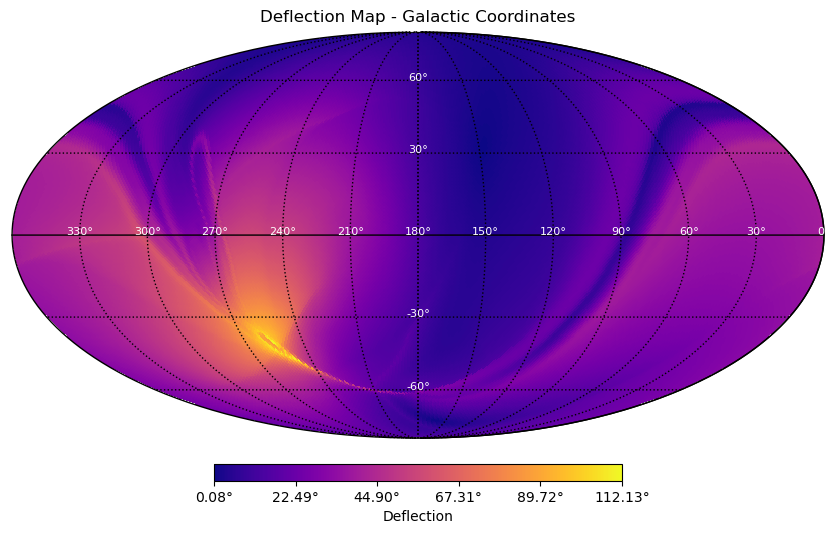

In [36]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# Load the CSV
data = np.loadtxt("../data/JF12_GMFdeflection_Z1_E10EeV.csv", delimiter=',', skiprows=1)

pixel_ids = data[:, 0].astype(int)
l_deg = data[:, 1]     # Galactic longitude (degrees)
b_deg = data[:, 2]     # Galactic latitude (degrees)
deflection = data[:, 3]

# Infer nside from pixel count
npix = int(np.max(pixel_ids)) + 1
nside = hp.npix2nside(npix)
print(f"Inferred nside: {nside} (npix = {npix})")

# Initialize HEALPix map
deflection_map = np.full(npix, hp.UNSEEN)  # Default to UNSEEN
deflection_map[pixel_ids] = deflection

# Mollweide projection in Galactic coordinates
hp.mollview(deflection_map,
            title="Deflection Map - Galactic Coordinates",
            rot=(180,0,0),
            #unit="degrees",
            cmap="plasma",
            coord='G',  # 'G' = Galactic
            notext=True)#,
            #cbar=True)

# Add coordinate grid
hp.graticule()

# Label selected longitudes (at b = 0°)
for lon in np.arange(0, 360, 30):
    hp.projtext(lon, 0, f"{lon}°", lonlat=True, fontsize=8, color='white', ha='center')

# Label selected latitudes (at l = 0°)
for lat in np.arange(-60, 91, 30):
    if lat != 0:
         hp.projtext(180, lat, f"{lat}°", lonlat=True, fontsize=8, color='white', ha='center')


# Customize colorbar ticks
cbar = plt.gcf().axes[-1]  # Get the colorbar axis
xticks = np.linspace(np.nanmin(deflection_map), np.nanmax(deflection_map), 6)
cbar.set_xticks(xticks)  
cbar.set_xticklabels([f"{tick:.2f}°" for tick in xticks], fontsize=10)
cbar.set_xlabel("Deflection", fontsize=10)

plt.tight_layout()
plt.show()



#### Plot in Equatorial Coordinates and plot galaxies

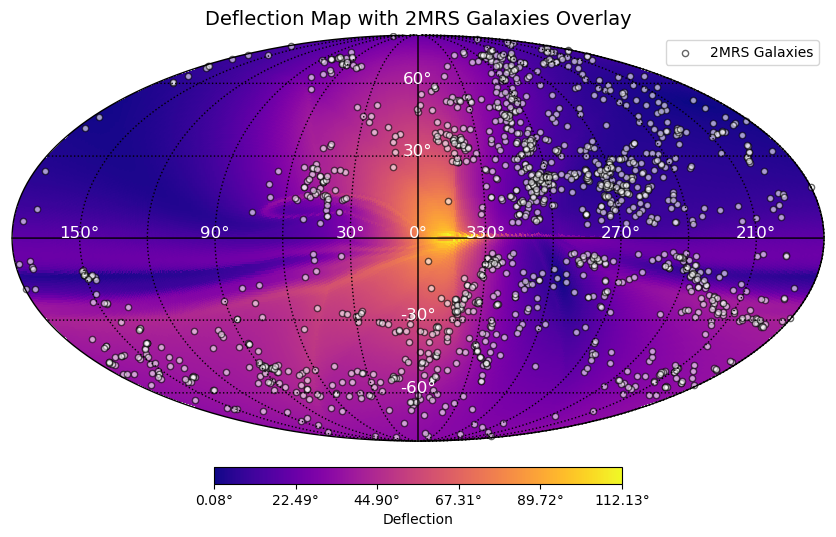

In [40]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u

# === Load deflection map ===
data = np.loadtxt("../data/JF12_GMFdeflection_Z1_E10EeV.csv", delimiter=',', skiprows=1)
pixel_ids = data[:, 0].astype(int)
l_deg = data[:, 1]
b_deg = data[:, 2]
deflection = data[:, 3]
npix = int(np.max(pixel_ids)) + 1
nside = hp.npix2nside(npix)

deflection_map = np.full(npix, hp.UNSEEN)
deflection_map[pixel_ids] = deflection


# === Load galaxy catalog ===
gal_data = ascii.read("../data/VLS_ang5_cz_700control_def.txt")
ra = gal_data['_RAJ2000']    # _RAJ2000
dec = gal_data['_DEJ2000']   # _DEJ2000

# === Convert galaxy positions to Galactic coordinates ===
gal_coords = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
galactic_coords = gal_coords.galactic
l_gal = galactic_coords.l.wrap_at(180*u.deg).degree  # Wrap at 180° for plotting
b_gal = galactic_coords.b.degree

# === Plot in RA/Dec ===
hp.mollview(deflection_map,
            title="Deflection Map with Galaxy Overlay",
            #rot=(0, 0, 0),  # center on RA=0
            cmap="plasma",
            coord=['C','G'],      # 'C' = Equatorial (RA/Dec)
            notext=True)

hp.graticule()

# Label selected longitudes (at b = 0°)
for lon in [0,30,90,150,210,270,330]:
    hp.projtext(lon, 0, f"{lon}°", lonlat=True, fontsize=12, color='white', ha='center')

# Label selected latitudes (at l = 0°)
for lat in np.arange(-60, 91, 30):
    if lat != 0:
         hp.projtext(0, lat, f"{lat}°", lonlat=True, fontsize=12, color='white', ha='center')


# Customize colorbar ticks
cbar = plt.gcf().axes[-1]  # Get the colorbar axis
xticks = np.linspace(np.nanmin(deflection_map), np.nanmax(deflection_map), 6)
cbar.set_xticks(xticks)  
cbar.set_xticklabels([f"{tick:.2f}°" for tick in xticks], fontsize=10)
cbar.set_xlabel("Deflection", fontsize=10)

# Overlay galaxies
hp.projscatter(l_gal, b_gal, lonlat=True, s=20, edgecolor='k', color='white', alpha=0.6, label='2MRS Galaxies')

plt.legend()
plt.title('Deflection Map with 2MRS Galaxies Overlay', fontsize=14)
plt.savefig("../plots/deflectionmap_galaxies.png")
plt.show()


##### Color galaxies according to deflection

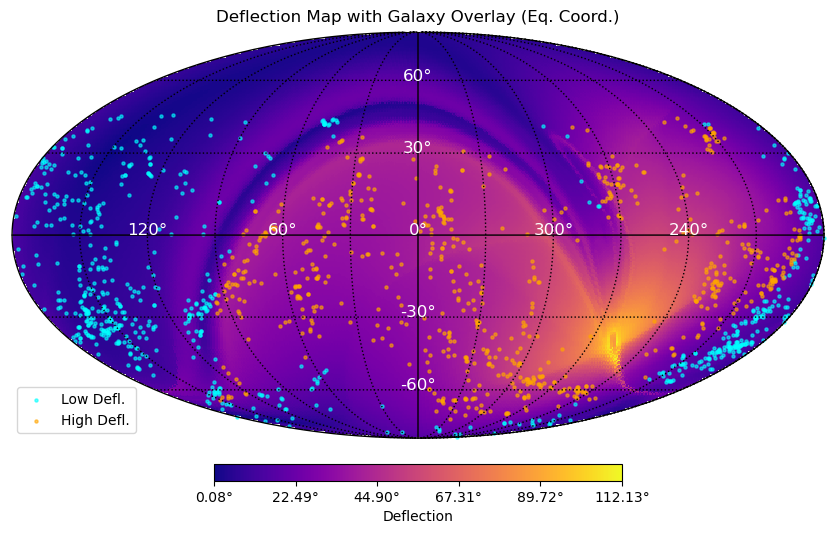

In [62]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# === Load deflection map ===
data = np.loadtxt("../data/JF12_GMFdeflection_Z1_E10EeV.csv", delimiter=',', skiprows=1)
pixel_ids = data[:, 0].astype(int)
l_deg = data[:, 1]
b_deg = data[:, 2]
deflection = data[:, 3]

npix = int(np.max(pixel_ids)) + 1
nside = hp.npix2nside(npix)
deflection_map = np.full(npix, hp.UNSEEN)
deflection_map[pixel_ids] = deflection

# === Load galaxy catalog ===
gal_data = ascii.read("../data/VLS_ang5_cz_700control_def.txt")
ra = gal_data['_RAJ2000']    # _RAJ2000
dec = gal_data['_DEJ2000']   # _DEJ2000
gal_defl = gal_data['deflection']  

# === Apply threshold to separate populations ===
threshold = np.median(gal_defl)
high_defl_mask = gal_defl > threshold
low_defl_mask = ~high_defl_mask

# === Plot deflection map in RA/Dec ===
hp.mollview(deflection_map,
            title="Deflection Map with Galaxy Overlay (Eq. Coord.)",
            rot=(0, 0, 0),
            cmap="plasma",
            coord='C',  # RA/Dec
            xsize=600,
            notext=True)

hp.graticule()

# Overlay galaxies: color by deflection threshold
hp.projscatter(ra[low_defl_mask], dec[low_defl_mask],
               lonlat=True, s=5, color='cyan', alpha=0.6, label='Low Defl.')

hp.projscatter(ra[high_defl_mask], dec[high_defl_mask],
               lonlat=True, s=5, color='orange', alpha=0.6, label='High Defl.')

# Label selected longitudes (at b = 0°)
for lon in [0,60,120,240,300]:
    hp.projtext(lon, 0, f"{lon}°", lonlat=True, fontsize=12, color='white', ha='center')

# Label selected latitudes (at l = 0°)
for lat in np.arange(-60, 91, 30):
    if lat != 0:
         hp.projtext(0, lat, f"{lat}°", lonlat=True, fontsize=12, color='white', ha='center')


# Customize colorbar ticks
cbar = plt.gcf().axes[-1]  # Get the colorbar axis
xticks = np.linspace(np.nanmin(deflection_map), np.nanmax(deflection_map), 6)
cbar.set_xticks(xticks)  
cbar.set_xticklabels([f"{tick:.2f}°" for tick in xticks], fontsize=10)
cbar.set_xlabel("Deflection", fontsize=10)

# Optional: add a legend
plt.legend(loc='lower left')

plt.show()


#### Create HIGH/LOW DEFL. MASK

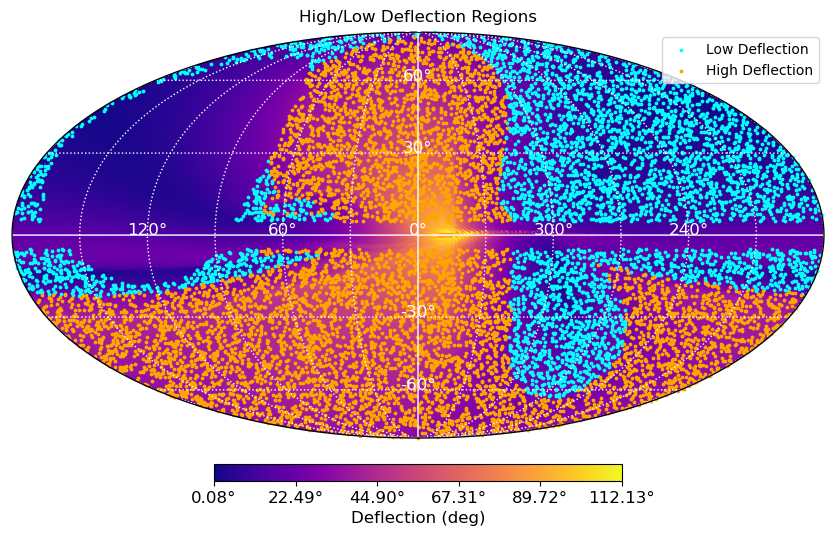

In [41]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

defl_file = "../data/JF12_GMFdeflection_Z1_E10EeV.csv"

# === Random points on sky ===
n_rand = 15000
rand_theta = np.arccos(1 - 2 * np.random.rand(n_rand))  # θ = 0 is north pole
rand_phi = 2 * np.pi * np.random.rand(n_rand)
rand_ra = np.degrees(rand_phi)
rand_dec = 90 - np.degrees(rand_theta)

rand_dec = rand_dec[rand_dec < 45.0]  # Limit to dec < 45°
rand_ra = rand_ra[:len(rand_dec)]  # Ensure same length

# === Function to apply mask ===
def apply_deflection_mask(defl_file, ra_deg, dec_deg, mask):

    # === Load/prepare deflection map ===
    data = np.loadtxt(defl_file, delimiter=',', skiprows=1)
    pixel_ids = data[:, 0].astype(int)
    deflection = data[:, 3]
    npix = int(np.max(pixel_ids)) + 1
    nside = hp.npix2nside(npix)
    deflection_map = np.full(npix, hp.UNSEEN)
    deflection_map[pixel_ids] = deflection

    # === Create binary masks ===
    valid = deflection_map != hp.UNSEEN
    threshold = np.median(deflection_map[valid])
    if mask=='high':
        mask = np.zeros_like(deflection_map, dtype=bool)
        mask[valid] = deflection_map[valid] > threshold
    elif mask=='low':
        mask = np.zeros_like(deflection_map, dtype=bool)
        mask[valid] = deflection_map[valid] <= threshold

    theta = np.radians(90 - dec_deg)
    phi = np.radians(ra_deg)
    pix = hp.ang2pix(nside, theta, phi)
    return mask[pix]

# Apply mask
in_high = apply_deflection_mask(defl_file, rand_ra, rand_dec, 'high')
in_low = apply_deflection_mask(defl_file, rand_ra, rand_dec, 'low')

# === Plot the deflection map and randoms ===
hp.mollview(deflection_map,
            title="High/Low Deflection Regions",
            cmap="plasma",
            coord=['C','G'],
            notext=True)

hp.graticule(color='white')

# === Convert galaxy positions to Galactic coordinates ===
gal_coords_low = SkyCoord(ra=rand_ra[in_low]*u.degree, dec=rand_dec[in_low]*u.degree, frame='icrs')
galactic_coords_low = gal_coords_low.galactic
l_ran_low = galactic_coords_low.l.wrap_at(180*u.deg).degree  # Wrap at 180° for plotting
b_ran_low = galactic_coords_low.b.degree
l_ran_low = l_ran_low[(b_ran_low > 5.)|(b_ran_low< -5.)]  # Mask out milky way
b_ran_low = b_ran_low[(b_ran_low > 5.)|(b_ran_low< -5.)]  # Mask out milky way

gal_coords_high = SkyCoord(ra=rand_ra[in_high]*u.degree, dec=rand_dec[in_high]*u.degree, frame='icrs')
galactic_coords_high = gal_coords_high.galactic
l_ran_high = galactic_coords_high.l.wrap_at(180*u.deg).degree  # Wrap at 180° for plotting
b_ran_high = galactic_coords_high.b.degree
l_ran_high = l_ran_high[(b_ran_high > 5.)|(b_ran_high < -5.)]  # Mask out mikly way
b_ran_high = b_ran_high[(b_ran_high > 5.)|(b_ran_high < -5.)]  # Mask out mikly way


# Overlay randoms
hp.projscatter(l_ran_low, b_ran_low,
               lonlat=True, s=3, color='cyan', alpha=1, label='Low Deflection')

hp.projscatter(l_ran_high, b_ran_high,
               lonlat=True, s=3, color='orange', alpha=1, label='High Deflection')


# Label selected longitudes (at b = 0°)
for lon in [0,60,120,240,300]:
    hp.projtext(lon, 0, f"{lon}°", lonlat=True, fontsize=12, color='white', ha='center')

# Label selected latitudes (at l = 0°)
for lat in np.arange(-60, 91, 30):
    if lat != 0:
         hp.projtext(0, lat, f"{lat}°", lonlat=True, fontsize=12, color='white', ha='center')


# Customize colorbar ticks
cbar = plt.gcf().axes[-1]  # Get the colorbar axis
xticks = np.linspace(np.nanmin(deflection_map), np.nanmax(deflection_map), 6)
cbar.set_xticks(xticks)  
cbar.set_xticklabels([f"{tick:.2f}°" for tick in xticks], fontsize=12)
cbar.set_xlabel("Deflection (deg)", fontsize=12)

# Add legend
plt.legend(loc='upper right')

plt.savefig("../plots/deflectionmap_randoms.png")
plt.show()



## Smoothing

/tmp/ipykernel_13526/3288279651.py:19: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  smoothed_map = hp.smoothing(deflection_map, fwhm=fwhm_rad, verbose=False)


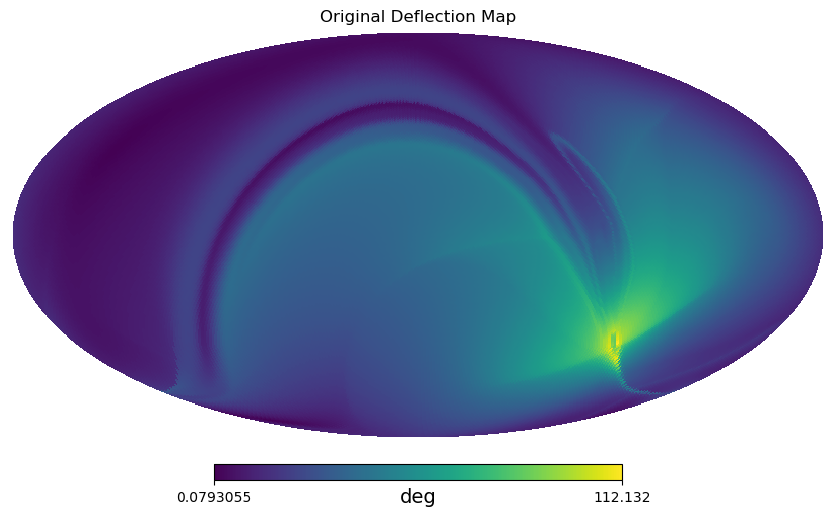

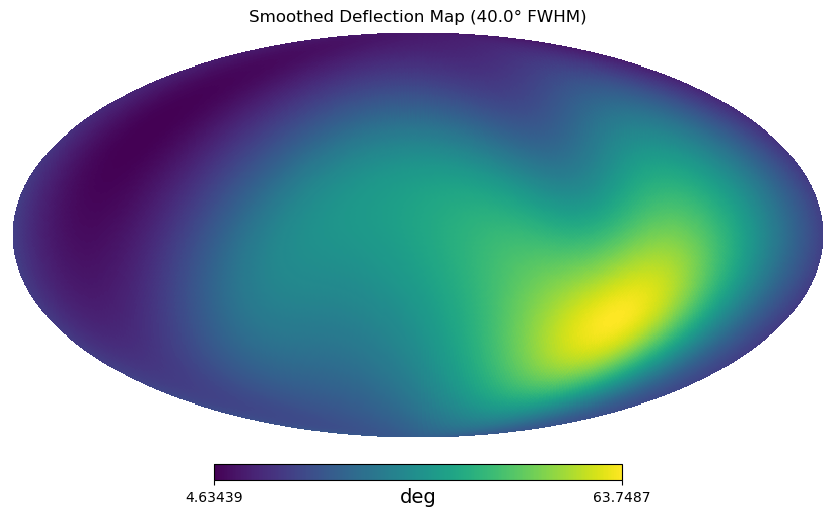

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

# === Load/prepare deflection map ===
defl_file = "../data/JF12_GMFdeflection_Z1_E10EeV.csv"
data = np.loadtxt(defl_file, delimiter=',', skiprows=1)
pixel_ids = data[:, 0].astype(int)
deflection = data[:, 3]
npix = int(np.max(pixel_ids)) + 1
nside = hp.npix2nside(npix)

deflection_map = np.full(npix, hp.UNSEEN)
deflection_map[pixel_ids] = deflection

# === Smooth the map ===
fwhm_deg = 40.0               # desired smoothing in degrees
fwhm_rad = np.radians(fwhm_deg)
smoothed_map = hp.smoothing(deflection_map, fwhm=fwhm_rad, verbose=False)

# === Plot ===
hp.mollview(deflection_map, title="Original Deflection Map", unit="deg")
hp.mollview(smoothed_map, title=f"Smoothed Deflection Map ({fwhm_deg}° FWHM)", unit="deg")
plt.show()
